In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Add the fourier_learning_ibm package to the path
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']


In [3]:
from pycaret.regression import RegressionExperiment
import pickle
import json
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

from heisenberg_graph import (
    extract_probs,
)

In [4]:
# Only for CP1
%cd fourier_learning_ibm/

/home/jovyan/fourier_learning_ibm


In [5]:
# Load parameters
CURRENT_TIME = "2024-12-01T06:22Z"
path = f"./data/{CURRENT_TIME}"

# Load the graphs as a binary file
with open(f"{path}/params_object.pkl", "rb") as f:
    params_object = pickle.load(f)

graphs = params_object["graphs"]
all_Js = params_object["Js"]
all_expected_values = params_object["expected_values"]

for key, value in params_object.items():
    print(f"{key}: {value}")

# Load the parameters as a JSON file
with open(f"{path}/params_text.json", "r") as f:
    params = json.load(f)

n_samples = params["n_samples"]
n_qubits = params["n_qubits"]
graph_type = params["graph_type"]
backend_qpu_name = params["backend_qpu_name"]
beta = params["beta"]
C = params["C"]
n_features = params["n_features"]
times = params["times"]

for key, value in params.items():
    print(f"{key}: {value}")

graphs: [<networkx.classes.graph.Graph object at 0x7f9ce54af610>, <networkx.classes.graph.Graph object at 0x7f9ce54b40d0>, <networkx.classes.graph.Graph object at 0x7f9ce54b4890>, <networkx.classes.graph.Graph object at 0x7f9ce54b5050>, <networkx.classes.graph.Graph object at 0x7f9ce54b5810>, <networkx.classes.graph.Graph object at 0x7f9ce54b5fd0>, <networkx.classes.graph.Graph object at 0x7f9ce54b6790>, <networkx.classes.graph.Graph object at 0x7f9ce54b6f50>, <networkx.classes.graph.Graph object at 0x7f9ce54b7710>, <networkx.classes.graph.Graph object at 0x7f9ce54b7ed0>, <networkx.classes.graph.Graph object at 0x7f9ce52c86d0>, <networkx.classes.graph.Graph object at 0x7f9ce52c8e90>, <networkx.classes.graph.Graph object at 0x7f9ce52c9650>, <networkx.classes.graph.Graph object at 0x7f9ce52c9e10>, <networkx.classes.graph.Graph object at 0x7f9ce52ca5d0>, <networkx.classes.graph.Graph object at 0x7f9ce52cad90>, <networkx.classes.graph.Graph object at 0x7f9ce52cb550>, <networkx.classes.grap

## Plot probability

In [6]:
# Load the data as a json file
with open(f"{path}/probs_phase0_exact.json", "r") as f:
    probs_phase0_exact = json.load(f)
with open(f"{path}/probs_phase1_exact.json", "r") as f:
    probs_phase1_exact = json.load(f)
with open(f"{path}/probs_phase2_exact.json", "r") as f:
    probs_phase2_exact = json.load(f)
with open(f"{path}/probs_phase3_exact.json", "r") as f:
    probs_phase3_exact = json.load(f)

In [7]:
with open(f"{path}/probs_phase0_sim.json", "r") as f:
    probs_phase0_sim = json.load(f)
with open(f"{path}/probs_phase1_sim.json", "r") as f:
    probs_phase1_sim = json.load(f)
with open(f"{path}/probs_phase2_sim.json", "r") as f:
    probs_phase2_sim = json.load(f)
with open(f"{path}/probs_phase3_sim.json", "r") as f:
    probs_phase3_sim = json.load(f)

In [8]:
with open(f"{path}/probs_phase0_sim_noisy.json", "r") as f:
    probs_phase0_sim_noisy = json.load(f)
with open(f"{path}/probs_phase1_sim_noisy.json", "r") as f:
    probs_phase1_sim_noisy = json.load(f)
with open(f"{path}/probs_phase2_sim_noisy.json", "r") as f:
    probs_phase2_sim_noisy = json.load(f)
with open(f"{path}/probs_phase3_sim_noisy.json", "r") as f:
    probs_phase3_sim_noisy = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: './data/2024-12-01T06:22Z/probs_phase0_sim_noisy.json'

In [ ]:
with open(f"{path}/probs_phase0_nmit.json", "r") as f:
    probs_phase0_nmit = json.load(f)
with open(f"{path}/probs_phase1_nmit.json", "r") as f:
    probs_phase1_nmit = json.load(f)
with open(f"{path}/probs_phase2_nmit.json", "r") as f:
    probs_phase2_nmit = json.load(f)
with open(f"{path}/probs_phase3_nmit.json", "r") as f:
    probs_phase3_nmit = json.load(f)

with open(f"{path}/probs_phase0_mit.json", "r") as f:
    probs_phase0_mit = json.load(f)
with open(f"{path}/probs_phase1_mit.json", "r") as f:
    probs_phase1_mit = json.load(f)
with open(f"{path}/probs_phase2_mit.json", "r") as f:
    probs_phase2_mit = json.load(f)
with open(f"{path}/probs_phase3_mit.json", "r") as f:
    probs_phase3_mit = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: './data/2024-12-01T05:41Z/probs_phase0_nmit.json'

In [9]:
with open(f"{path}/successful_job_ids_and_samples.json", "r") as f:
    successful_job_ids_and_samples = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: './data/2024-12-01T06:22Z/successful_job_ids_and_samples.json'

In [10]:
# For debugging
dummy_successful_job_ids_and_samples = {}
for i in range(n_samples):
    dummy_successful_job_ids_and_samples[f"sample{i}"] = None

successful_job_ids_and_samples = dummy_successful_job_ids_and_samples

In [11]:
probs_phase0_exact_extracted = extract_probs(
    probs_phase0_exact, successful_job_ids_and_samples.keys()
)
probs_phase1_exact_extracted = extract_probs(
    probs_phase1_exact, successful_job_ids_and_samples.keys()
)
probs_phase2_exact_extracted = extract_probs(
    probs_phase2_exact, successful_job_ids_and_samples.keys()
)
probs_phase3_exact_extracted = extract_probs(
    probs_phase3_exact, successful_job_ids_and_samples.keys()
)

In [12]:
probs_phase0_sim_extracted = extract_probs(
    probs_phase0_sim, successful_job_ids_and_samples.keys()
)
probs_phase1_sim_extracted = extract_probs(
    probs_phase1_sim, successful_job_ids_and_samples.keys()
)
probs_phase2_sim_extracted = extract_probs(
    probs_phase2_sim, successful_job_ids_and_samples.keys()
)
probs_phase3_sim_extracted = extract_probs(
    probs_phase3_sim, successful_job_ids_and_samples.keys()
)

In [13]:
probs_phase0_sim_noisy_extracted = extract_probs(
    probs_phase0_sim_noisy, successful_job_ids_and_samples.keys()
)
probs_phase1_sim_noisy_extracted = extract_probs(
    probs_phase1_sim_noisy, successful_job_ids_and_samples.keys()
)
probs_phase2_sim_noisy_extracted = extract_probs(
    probs_phase2_sim_noisy, successful_job_ids_and_samples.keys()
)
probs_phase3_sim_noisy_extracted = extract_probs(
    probs_phase3_sim_noisy, successful_job_ids_and_samples.keys()
)

NameError: name 'probs_phase0_sim_noisy' is not defined

In [14]:
probs_phase0_nmit_extracted = extract_probs(
    probs_phase0_nmit, successful_job_ids_and_samples.keys()
)
probs_phase1_nmit_extracted = extract_probs(
    probs_phase1_nmit, successful_job_ids_and_samples.keys()
)
probs_phase2_nmit_extracted = extract_probs(
    probs_phase2_nmit, successful_job_ids_and_samples.keys()
)
probs_phase3_nmit_extracted = extract_probs(
    probs_phase3_nmit, successful_job_ids_and_samples.keys()
)

probs_phase0_mit_extracted = extract_probs(
    probs_phase0_mit, successful_job_ids_and_samples.keys()
)
probs_phase1_mit_extracted = extract_probs(
    probs_phase1_mit, successful_job_ids_and_samples.keys()
)
probs_phase2_mit_extracted = extract_probs(
    probs_phase2_mit, successful_job_ids_and_samples.keys()
)
probs_phase3_mit_extracted = extract_probs(
    probs_phase3_mit, successful_job_ids_and_samples.keys()
)

NameError: name 'probs_phase0_nmit' is not defined

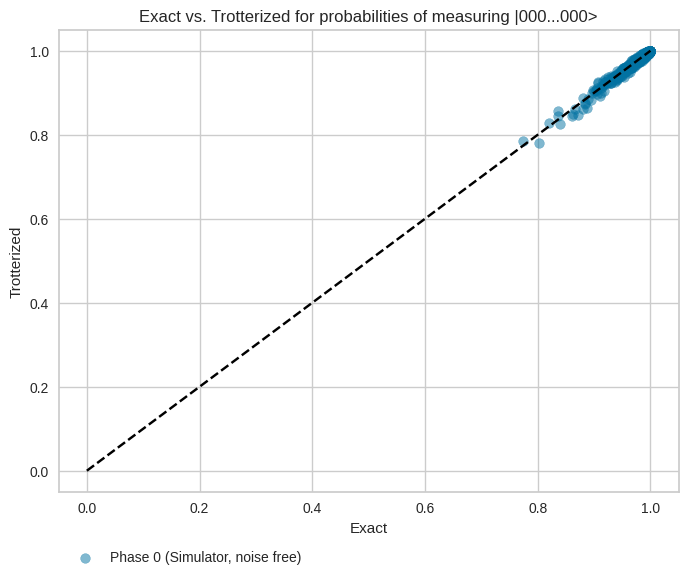

In [15]:
# Plot exact vs. Trotterized results
plt.figure(figsize=(8, 6))
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_sim_extracted,
    label=f"Phase 0 (Simulator, noise free)",
    alpha=0.5,
)
# plt.scatter(
#     probs_phase0_exact_extracted,
#     probs_phase0_sim_noisy_extracted,
#     label=f"Phase 0 (Simulator: noise_model:{backend_qpu_name})",
#     alpha=0.5,
# )
# plt.scatter(
#     probs_phase0_exact_extracted,
#     probs_phase0_nmit_extracted,
#     label=f"Phase 0 (QPU: {backend_qpu_name}, no mitigation)",
#     alpha=0.5,
# )
# plt.scatter(
#     probs_phase0_exact_extracted,
#     probs_phase0_mit_extracted,
#     label=f"Phase 0 (QPU: {backend_qpu_name}, with mitigation)",
#     alpha=0.5,
# )
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

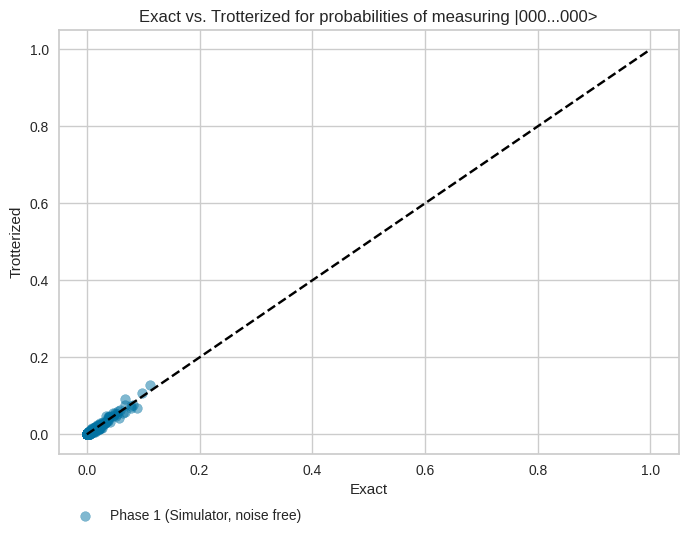

In [16]:
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_sim_extracted,
    label=f"Phase 1 (Simulator, noise free)",
    alpha=0.5,
)
# plt.scatter(
#     probs_phase1_exact_extracted,
#     probs_phase1_sim_noisy_extracted,
#     label=f"Phase 1 (Simulator, noise_model:{backend_qpu_name})",
#     alpha=0.5,
# )
# plt.scatter(
#     probs_phase1_exact_extracted,
#     probs_phase1_nmit_extracted,
#     label=f"Phase 1 (QPU: {backend_qpu_name}, no mitigation)",
#     alpha=0.5,
# )
# plt.scatter(
#     probs_phase1_exact_extracted,
#     probs_phase1_mit_extracted,
#     label=f"Phase 1 (QPU: {backend_qpu_name}, with mitigation)",
#     alpha=0.5,
# )
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

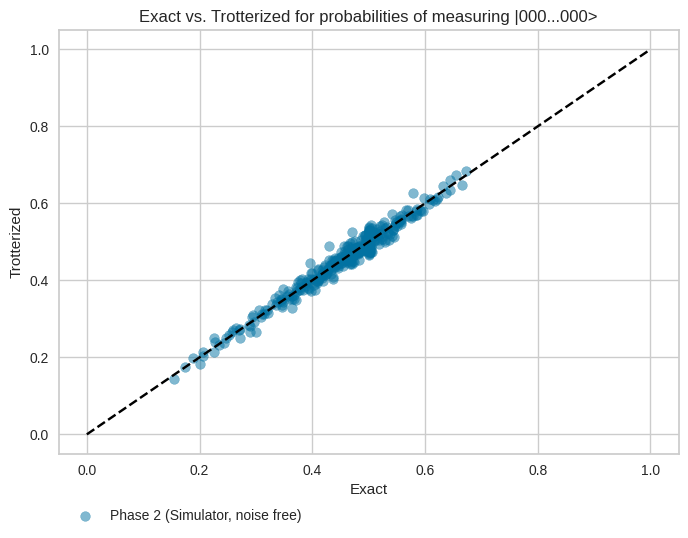

In [17]:
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_sim_extracted,
    label=f"Phase 2 (Simulator, noise free)",
    alpha=0.5,
)
# plt.scatter(
#     probs_phase2_exact_extracted,
#     probs_phase2_sim_noisy_extracted,
#     label=f"Phase 2 (Simulator: noise_model:{backend_qpu_name})",
#     alpha=0.5,
# )
# plt.scatter(
#     probs_phase2_exact_extracted,
#     probs_phase2_nmit_extracted,
#     label=f"Phase 2 (QPU: {backend_qpu_name}, no mitigation)",
#     alpha=0.5,
# )
# plt.scatter(
#     probs_phase2_exact_extracted,
#     probs_phase2_mit_extracted,
#     label=f"Phase 2 (QPU: {backend_qpu_name}, with mitigation)",
#     alpha=0.5,
# )
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")

plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

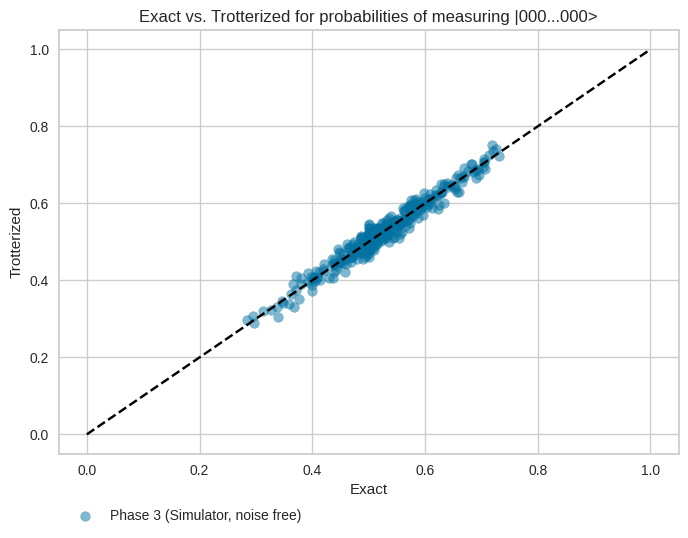

In [18]:
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_sim_extracted,
    label=f"Phase 3 (Simulator, noise free)",
    alpha=0.5,
)
# plt.scatter(
#     probs_phase3_exact_extracted,
#     probs_phase3_sim_noisy_extracted,
#     label=f"Phase 3 (Simulator: noise_model:{backend_qpu_name})",
#     alpha=0.5,
# )
# plt.scatter(
#     probs_phase3_exact_extracted,
#     probs_phase3_nmit_extracted,
#     label=f"Phase 3 (QPU: {backend_qpu_name}, no mitigation)",
#     alpha=0.5,
# )
# plt.scatter(
#     probs_phase3_exact_extracted,
#     probs_phase3_mit_extracted,
#     label=f"Phase 3 (QPU: {backend_qpu_name}, with mitigation)",
#     alpha=0.5,
# )
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

## Regression

In [19]:
data_exact_df = pd.read_json(f"{path}/data_exact_df.json")

In [20]:
data_sim_df = pd.read_json(f"{path}/data_sim_df.json")

In [21]:
data_sim_noisy_df = pd.read_json(f"{path}/data_sim_noisy_df.json")

FileNotFoundError: File ./data/2024-12-01T06:22Z/data_sim_noisy_df.json does not exist

In [22]:
data_nmit_df = pd.read_json(f"{path}/data_qpu_nmit_df.json")
data_mit_df = pd.read_json(f"{path}/data_qpu_mit_df.json")

FileNotFoundError: File ./data/2024-12-01T06:22Z/data_qpu_nmit_df.json does not exist

In [23]:
# For debugging
data_mit_df = data_exact_df

In [24]:
# Extract features which have overlap with data_mit_df (i.e. successful samples)
data_exact_df = data_exact_df[data_exact_df.index.isin(data_mit_df.sample_id)]

In [25]:
data_sim_df = data_sim_df[data_sim_df.index.isin(data_mit_df.sample_id)]

In [26]:
data_sim_noisy_df = data_sim_noisy_df[
    data_sim_noisy_df.index.isin(data_mit_df.sample_id)
]

NameError: name 'data_sim_noisy_df' is not defined

In [27]:
data_nmit_df = data_nmit_df[data_nmit_df.index.isin(data_mit_df.sample_id)]

NameError: name 'data_nmit_df' is not defined

In [28]:
print("Exact")
display(data_exact_df)

Exact


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,1,0.995665,0.060524,0.982748,0.119980,0.961518,0.177326,0.932407,0.231577,7.391106
1,1,1,0.991181,-0.041044,0.965030,-0.080889,0.922459,-0.118369,0.864942,-0.152373,7.380861
2,2,1,0.996789,-0.033491,0.987194,-0.066559,0.971330,-0.098788,0.949383,-0.129763,1.560675
3,3,1,0.995513,0.031830,0.982154,0.063129,0.960223,0.093374,0.930214,0.122055,5.663484
4,4,1,0.994698,-0.035861,0.978973,-0.070355,0.953362,-0.102191,0.918728,-0.130223,1.889904
...,...,...,...,...,...,...,...,...,...,...,...
75,75,1,0.998766,-0.001185,0.995070,-0.002341,0.988931,-0.003436,0.980382,-0.004441,1.463780
76,76,1,0.998277,0.040170,0.993122,0.080191,0.984580,0.119914,0.972725,0.159194,2.774891
77,77,1,0.999460,0.023593,0.997843,0.047148,0.995152,0.070626,0.991395,0.093989,1.709296
78,78,1,0.996589,-0.059547,0.986395,-0.118490,0.969539,-0.176232,0.946221,-0.232188,0.794244


In [29]:
print("Simulator (noise free)")
display(data_sim_df)

Simulator (noise free)


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,1,0.997367,0.040252,0.974962,0.096152,0.972094,0.188465,0.933605,0.199769,7.391106
1,1,1,0.986418,0.001405,0.956969,-0.115257,0.910609,-0.146262,0.874614,-0.151469,7.380861
2,2,1,0.995852,-0.053364,0.979728,-0.090975,0.979296,-0.079186,0.951882,-0.126306,1.560675
3,3,1,0.996624,-0.015779,0.985944,0.029551,0.953698,0.099610,0.922680,0.123570,5.663484
4,4,1,0.993478,0.007690,0.978034,-0.041359,0.962543,-0.129816,0.906745,-0.159644,1.889904
...,...,...,...,...,...,...,...,...,...,...,...
75,75,1,0.996925,0.018317,0.992653,0.033611,0.986178,0.021380,0.980207,0.007056,1.463780
76,76,1,0.997273,0.046638,0.992061,0.082701,0.992303,0.095204,0.958700,0.192901,2.774891
77,77,1,1.000073,0.009892,0.998342,0.019698,0.993332,0.099688,0.989769,0.131797,1.709296
78,78,1,0.997879,-0.049714,0.985215,-0.109974,0.972721,-0.159620,0.944004,-0.254002,0.794244


In [30]:
print("Simulator (noisy)")
display(data_sim_noisy_df)

Simulator (noisy)


NameError: name 'data_sim_noisy_df' is not defined

In [31]:
print("no mitigation")
display(data_nmit_df)

print("mitigation")
display(data_mit_df)

no mitigation


NameError: name 'data_nmit_df' is not defined

## Exact

In [32]:
train_size = 0.8
session_id = 42

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(80, 11)"
4,Transformed data shape,"(80, 10)"
5,Transformed train set shape,"(64, 10)"
6,Transformed test set shape,"(16, 10)"
7,Ignore features,9
8,Numeric features,9
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.1204,0.0401,0.1746,0.9826,0.0547,0.0774,0.3510
huber,Huber Regressor,0.6283,0.9826,0.8304,0.8031,0.2064,0.3417,0.1810
et,Extra Trees Regressor,0.7119,1.0096,0.9712,0.6894,0.2216,0.3304,0.0420
rf,Random Forest Regressor,0.8412,1.5394,1.1275,0.6429,0.2713,0.4022,0.0530
gbr,Gradient Boosting Regressor,0.8124,1.3263,1.0790,0.6113,0.2597,0.3756,0.0170
ada,AdaBoost Regressor,0.9602,1.6844,1.2249,0.5677,0.3302,0.6385,0.0180
knn,K Neighbors Regressor,1.0886,2.4059,1.4045,0.4769,0.3427,0.5986,0.0160
lightgbm,Light Gradient Boosting Machine,1.2340,2.8886,1.5275,0.3726,0.4160,0.9643,0.3330
ridge,Ridge Regression,1.3762,3.2790,1.6676,0.3392,0.4273,0.9009,0.1950
br,Bayesian Ridge,1.0406,1.7882,1.2015,0.3168,0.3171,0.9508,0.2020


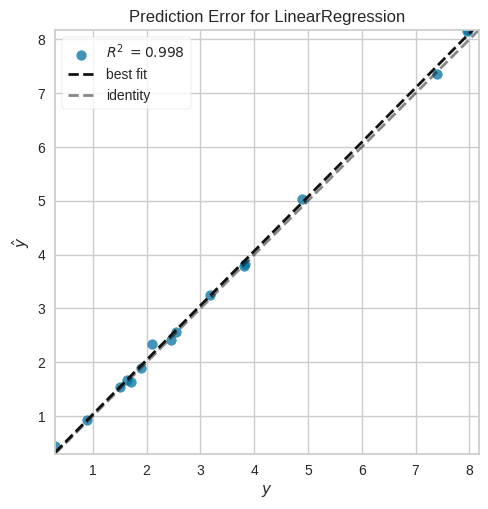

In [33]:
s_exact = RegressionExperiment()
s_exact.setup(
    data=data_exact_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=train_size,
    session_id=session_id,
)
best_exact = s_exact.compare_models(turbo=True, sort="R2")

s_exact.plot_model(best_exact, plot="error")

## Trotter (Simulation, Noise free)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(80, 11)"
4,Transformed data shape,"(80, 10)"
5,Transformed train set shape,"(64, 10)"
6,Transformed test set shape,"(16, 10)"
7,Ignore features,9
8,Numeric features,9
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.7825,1.2436,1.0411,0.6659,0.2701,0.4607,0.0400
ada,AdaBoost Regressor,1.0016,1.9619,1.2752,0.5600,0.3389,0.6537,0.0180
br,Bayesian Ridge,1.0711,2.1764,1.3566,0.4918,0.3237,0.5165,0.0110
gbr,Gradient Boosting Regressor,0.9674,1.8698,1.2931,0.4801,0.3221,0.5118,0.0160
rf,Random Forest Regressor,1.0184,2.1617,1.3517,0.4649,0.3473,0.5922,0.0510
huber,Huber Regressor,1.1054,2.2831,1.3919,0.4379,0.3237,0.5534,0.0130
knn,K Neighbors Regressor,1.1986,2.7904,1.5400,0.3751,0.3761,0.6514,0.0140
ridge,Ridge Regression,1.4009,3.3279,1.6818,0.3288,0.4301,0.9245,0.0090
lightgbm,Light Gradient Boosting Machine,1.2593,2.7976,1.5457,0.2905,0.4262,0.9419,0.2000
lr,Linear Regression,1.1561,2.5285,1.4875,0.2861,0.3444,0.5848,0.0110


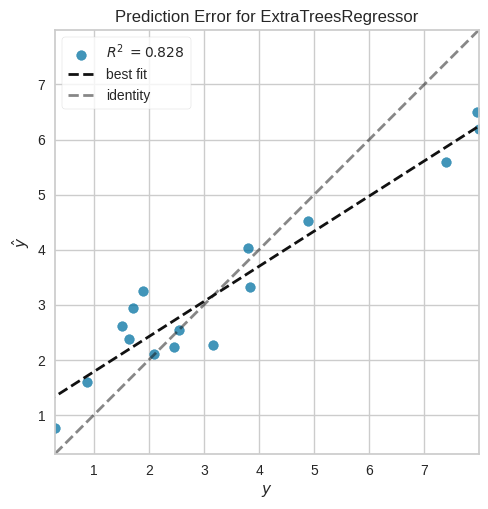

In [34]:
s_sim = RegressionExperiment()
s_sim.setup(
    data=data_sim_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=train_size,
    session_id=session_id,
)
best_sim = s_sim.compare_models(turbo=True, sort="R2")

s_sim.plot_model(best_sim, plot="error")

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,06:29:17
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4447,0.2688,0.5184,0.9053,0.2393,0.5825
1,0.9445,1.4965,1.2233,0.7495,0.2649,0.3179
2,0.7528,1.1617,1.0778,0.7838,0.2008,0.3956
3,0.5646,0.5598,0.7482,0.7415,0.2102,0.2285
4,0.8091,1.2716,1.1277,0.8674,0.2908,0.5783
5,0.6483,0.5363,0.7323,0.5319,0.2686,0.4689
6,0.4323,0.3282,0.5729,0.9128,0.2678,0.7731
7,1.3679,2.2581,1.5027,0.7394,0.3228,0.4877
8,1.1004,3.4559,1.8590,0.4631,0.3338,0.2321


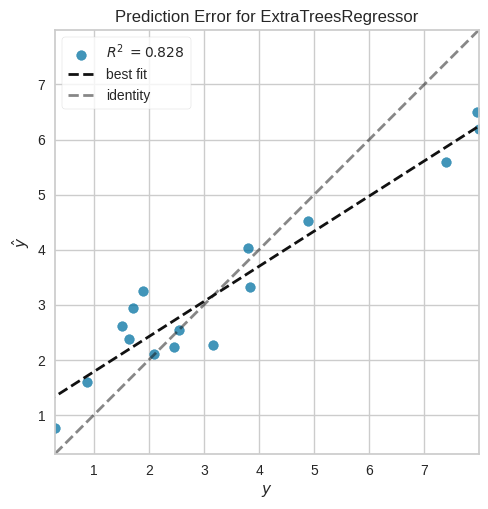

In [35]:
manual_model_sim = s_sim.create_model("et")
s_sim.plot_model(manual_model_sim, plot="error")

## Trotter (Simulation, Noisy)

In [ ]:
s_sim_noisy = RegressionExperiment()
s_sim_noisy.setup(
    data=data_sim_noisy_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=train_size,
    session_id=session_id,
)
best_sim_noisy = s_sim_noisy.compare_models(turbo=True, sort="MSE")
s_sim_noisy.plot_model(best_sim_noisy, plot="error")

## Trotter (QPU, no mitigation)

In [ ]:
s_nmit = RegressionExperiment()
s_nmit.setup(
    data=data_nmit_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=train_size,
    session_id=session_id,
)
best_nmit = s_nmit.compare_models(turbo=True, sort="MSE")
s_nmit.plot_model(best_nmit, plot="error")

In [ ]:
manual_model_nmit = s_nmit.create_model("knn")
s_nmit.plot_model(manual_model_nmit, plot="error")

In [ ]:
s_nmit.tune_model(best_nmit, optimize="MSE", choose_better=True)
s_nmit.plot_model(best_nmit, plot="error")

## Trotter (QPU, mitigation)

In [ ]:
s_mit = RegressionExperiment()
s_mit.setup(
    data=data_mit_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=train_size,
    session_id=session_id,
)
best_mit = s_mit.compare_models(turbo=True, sort="MSE")

In [ ]:
holdout_pred_mit = s_mit.predict_model(best_mit)
display(holdout_pred_mit)

In [ ]:
s_mit.plot_model(best_mit, plot="error")

In [ ]:
s_mit.tune_model(best_mit, optimize="MSE", choose_better=True)
s_mit.plot_model(best_mit, plot="error")

In [ ]:
manual_model_mit = s_mit.create_model("et")
s_mit.plot_model(manual_model_mit, plot="error")

In [ ]:
tuned_manual_model_mit = s_mit.tune_model(manual_model_mit, optimize="R2")
s_mit.plot_model(tuned_manual_model_mit, plot="error")